## Environment Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 2.14 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name =

In [2]:
# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.04
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/models.git (to revision release-23.04) to /tmp/pip-req-build-p2sgn1k8
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/models.git /tmp/pip-req-build-p2sgn1k8
  Running command git checkout -b release-23.04 --track origin/release-23.04
  Switched to a new branch 'release-23.04'
  Branch 'release-23.04' set up to track remote branch 'release-23.04' from 'origin'.
  Resolved https://github.com/NVIDIA-Merlin/models.git to commit 56c7d6a4b2ec003472bdd176e972125632d070de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.4 MB/s eta 0:00:00
  Installing buil

## Prepare the Dataset
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/01-Download-Convert.ipynb


In [1]:
import os

from merlin.core.utils import download_file

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()
import numpy as np

In [2]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [3]:
data_path = os.path.join(DATA_DIR, "ml-100k")
if not os.path.isdir(data_path):
    download_file(
        "http://files.grouplens.org/datasets/movielens/ml-100k.zip",
        os.path.join(DATA_DIR, "ml-100k.zip"),
    )

In [4]:
data_path = DATA_DIR + 'ml-100k/'

# Load user ratings data
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_data = pd.read_csv(data_path + 'u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Load movie information data
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action',
               'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
               'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']
movies_data = pd.read_csv(data_path + 'u.item', sep='|', names=movies_cols, encoding='latin-1')

# Load user information data
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_data = pd.read_csv(data_path + 'u.user', sep='|', names=users_cols, encoding='latin-1')

# Step 3: Merge DataFrames
# Merge user ratings with movie information
merged_data = pd.merge(ratings_data, movies_data, on='movie_id')

# Merge the above DataFrame with user information
merged_data = pd.merge(merged_data, users_data, on='user_id')

# Combine the individual genre columns into a single categorical column
genre_cols = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama',
              'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']

# Create a new column 'genres' by concatenating the genre names if the value is 1
merged_data['genres'] = merged_data[genre_cols].apply(lambda row: '|'.join([col for col in genre_cols if row[col] == 1]), axis=1)

# Drop the individual genre columns + `unknown` + `video_release_date` + `imdb_url`
merged_data.drop(columns=genre_cols + ['unknown', 'video_release_date', 'imdb_url'], inplace=True)

# convert genres to a list
merged_data["genres"] = merged_data["genres"].str.split("|")

# Step 4: Save as parquet
merged_data.to_parquet(f'{DATA_DIR}/movielens_100k.parquet', index=False)

print("Conversion to parquet completed successfully.")

Conversion to parquet completed successfully.


In [5]:
merged_data

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"
...,...,...,...,...,...,...,...,...,...,...,...
99995,873,313,5,891392177,Titanic (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, romance]"
99996,873,326,4,891392656,G.I. Jane (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, war]"
99997,873,348,3,891392577,Desperate Measures (1998),30-Jan-1998,48,F,administrator,33763,"[crime, drama, thriller]"
99998,873,358,2,891392698,Spawn (1997),01-Aug-1997,48,F,administrator,33763,"[action, adventure, sci_fi, thriller]"


## ETL
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/02-ETL-with-NVTabular.ipynb

In [38]:
import os
import shutil
import numpy as np
from nvtabular.ops import *
from merlin.schema.tags import Tags

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [39]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [40]:
movies = pd.read_parquet(os.path.join(DATA_DIR, "movielens_100k.parquet"))
movies.head()

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"


In [41]:
# split train, val, test - 80,10,10
sorted_movies = movies.sort_values(by="timestamp")
test_size = int(len(movies) * 0.1)

# selective columns
cols = ['user_id', 'movie_id', 'rating',] #'title', 'gender', 'occupation']
sorted_movies = sorted_movies[cols]

train = sorted_movies[:-test_size * 2].sample(frac=1).reset_index(drop=True)
val = sorted_movies[-test_size * 2: -test_size].sample(frac=1).reset_index(drop=True)
test = sorted_movies[-test_size: ].sample(frac=1).reset_index(drop=True)

train.to_parquet(os.path.join(DATA_DIR, "train.parquet"))
val.to_parquet(os.path.join(DATA_DIR, "validation.parquet"))
test.to_parquet(os.path.join(DATA_DIR, "test.parquet"))

In [42]:
genres = movies[['movie_id','genres']]
def merge_list(srs):
    return list(set(item for sublist in srs for item in sublist))
genres = genres.groupby('movie_id')['genres'].agg(merge_list).reset_index()

In [43]:
genres

,movie_id,genres
0,1,"[children, animation, comedy]"
1,2,"[thriller, adventure, action]"
2,3,[thriller]
3,4,"[comedy, action, drama]"
4,5,"[thriller, crime, drama]"
...,...,...
1677,1678,[drama]
1678,1679,"[thriller, romance]"
1679,1680,"[romance, drama]"
1680,1681,[comedy]


In [44]:
# TODO title?
CATEGORICAL_COLUMNS = ["user_id", "movie_id", ]#"gender", "occupation"]
LABEL_COLUMNS = ["rating"]

In [45]:
userId = ["user_id"] >> TagAsUserID()
movieId = ["movie_id"] >> TagAsItemID()

joined = userId + movieId >> JoinExternal(genres, on=["movie_id"])
# joined.graph

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [46]:
# we will add Categorify for our categorical features
cat_features =  joined >> Categorify()

In [47]:
# The ratings are on a scale between 1-5. We want to predict a binary target with 1 for ratings >3 and 0 for ratings <=3
ratings = nvt.ColumnGroup(LABEL_COLUMNS) >> LambdaOp(lambda col: (col > 3).astype("int8")) >> AddTags(Tags.TARGET)

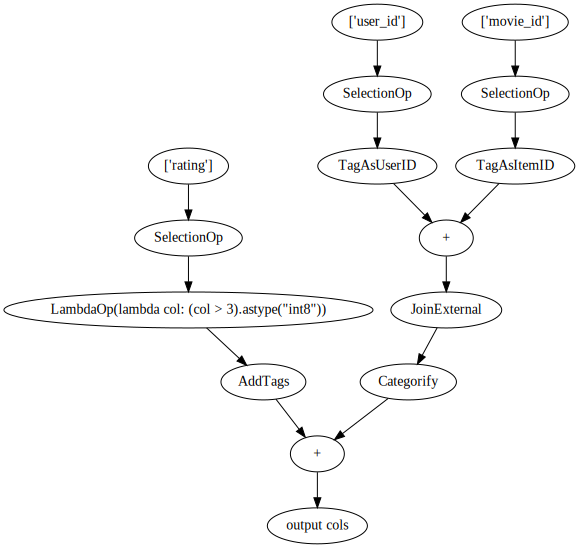

In [48]:
output = cat_features + ratings
(output).graph

In [49]:
workflow = nvt.Workflow(output)

In [50]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [51]:
train_dataset = nvt.Dataset([os.path.join(DATA_DIR, "train.parquet")])
val_dataset = nvt.Dataset([os.path.join(DATA_DIR, "validation.parquet")])
test_dataset = nvt.Dataset([os.path.join(DATA_DIR, "test.parquet")])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [52]:
%%time
workflow.fit(train_dataset)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:438: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.US

CPU times: user 468 ms, sys: 33 ms, total: 501 ms
Wall time: 521 ms


/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [53]:
# Make sure we have a clean output path
if path.exists(os.path.join(DATA_DIR, "pp_train")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_train"))
if path.exists(os.path.join(DATA_DIR, "pp_valid")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_valid"))
if path.exists(os.path.join(DATA_DIR, "pp_test")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_test"))

In [54]:
%%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


CPU times: user 403 ms, sys: 19.3 ms, total: 422 ms
Wall time: 472 ms


In [55]:
%%time
workflow.transform(val_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "valid"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

CPU times: user 101 ms, sys: 2.78 ms, total: 103 ms
Wall time: 159 ms


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [56]:
%%time
workflow.transform(test_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "test"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


CPU times: user 94.3 ms, sys: 6.04 ms, total: 100 ms
Wall time: 125 ms


In [57]:
workflow.save(os.path.join(DATA_DIR, "workflow"))
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,user_id,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.user_id.parquet,0.0,751.0,user_id,752.0,65.0,NaN,NaN
1,movie_id,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.movie_id.parquet,0.0,1616.0,movie_id,1617.0,100.0,NaN,NaN
2,genres,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,19.0,genres,20.0,16.0,0.0,NaN
3,rating,(Tags.TARGET),"DType(name='int8', element_type=<ElementType.I...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sanity Check

In [58]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "valid", "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test", "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test/part_0.parquet'])

In [59]:
df = pd.read_parquet(TRAIN_PATHS[0])
df.head()

,user_id,movie_id,genres,rating
0,256,9,"[8, 7, 3]",0.0
1,379,731,"[6, 3]",0.0
2,10,5,"[7, 1]",0.0
3,59,648,[2],0.0
4,57,594,[3],1.0


In [60]:
df = pd.read_parquet(VALID_PATHS[0])
df.head()

,user_id,movie_id,genres,rating
0,524,102,"[6, 5, 2, 3]",1.0
1,112,261,[1],1.0
2,0,427,[1],0.0
3,0,120,"[7, 3]",1.0
4,0,374,"[6, 3, 2, 4, 13]",0.0


In [61]:
df = pd.read_parquet(TEST_PATHS[0])
df.head()

,user_id,movie_id,genres,rating
0,0,532,"[16, 9, 4, 12]",1.0
1,0,127,[1],0.0
2,0,277,"[6, 7, 3]",0.0
3,0,409,[1],0.0
4,52,143,"[5, 1]",1.0


In [62]:
df = train_dataset.to_ddf().compute()

In [63]:
genres[genres['movie_id'] == 242]

,movie_id,genres
241,242,[comedy]
